# Second assignment: Analyse your "realistic" graph

## Load Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections, itertools
import networkx as nx

In [2]:
G = nx.Graph()
edges = nx.read_edgelist('../datasets/dataset.txt')
G.add_edges_from(edges.edges())
posTotal = nx.spring_layout(G)

## Dataset Information

Arxiv GR-QC (General Relativity and Quantum Cosmology) collaboration network is from the e-print arXiv and covers scientific collaborations between authors papers submitted to General Relativity and Quantum Cosmology category. If an author i co-authored a paper with author j, the graph contains a undirected edge from i to j. If the paper is co-authored by k authors this generates a completely connected (sub)graph on k nodes.

The data covers papers in the period from January 1993 to April 2003 (124 months). It begins within a few months of the inception of the arXiv, and thus represents essentially the complete history of its GR-QC section.

<img src="images/arXivGraph.png">

### Dataset stats (from https://snap.stanford.edu/data/ca-GrQc.html)
<img src="images/dataset.png">

## Node level measurements

In [ ]:
#Utils class

class statistics:
    
    def __init__(self, d, measure):
        self.measure = measure
        self.orderedList = sorted(list(d.items()), key=lambda pair: pair[1])
        self.orderedKeys = sorted(list(d.keys()))
        self.orderedValues = sorted(list(d.values()))
    
    def average(self):    
        return np.mean(self.orderedValues)

    def variance(self):
        return np.var(self.orderedValues)

    def maximum(self):
        return self.orderedList[-1]

    def minimum(self):
        return self.orderedList[0]

    def median(self):
        return self.orderedList[len(self.orderedList)//2]
    
    def print_info(self):
        print("{} distribution:\n\taverage: {}\n\tvariance: {}\n\tmaximum: {}\n\tminimum: {}\n\tmedian: {}\n"
              .format(self.measure,self.average(),self.variance(),
                      self.maximum(),self.minimum(),self.median()))
    
    def barplot(self):
        key, cnt = zip(*collections.Counter(self.orderedValues).items())

        plt.figure(figsize=(15,10))
        plt.bar(key, cnt, width=0.80, color='b')
        plt.title(self.measure+" barplot")
        plt.ylabel("Count")
        plt.xlabel(self.measure)
        plt.xticks(key, rotation=90)
        plt.tight_layout()
    
    def histogram(self, bins=10):
        plt.figure(figsize=(15,8))
        counts,bins,_ = plt.hist(self.orderedValues, bins=bins)
                                  
        bin_centers = 0.5 * np.diff(bins) + bins[:-1]
        for count, x in zip(counts, bin_centers):
            # Label the raw counts
            plt.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
                         xytext=(0, -20), textcoords='offset points', va='top', ha='center')
            # Label the percentages
            percent = '%0.0f%%' % (100 * float(count) / counts.sum())
            plt.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
                         xytext=(0, -35), textcoords='offset points', va='top', ha='center')
        
        plt.title(self.measure+" histogram")
        plt.ylabel("Count")
        plt.xticks(bins)
        plt.show()

### Degree distribution

<img src="images/measures/arXivDegree.png">

In [ ]:
degree_stat = statistics(dict(G.degree),"Degree")
degree_stat.print_info()
degree_stat.barplot()

### Betweenness

<img src="images/measures/arXivBetweenness.png">

In [ ]:
btwc = nx.betweenness_centrality(G)

In [ ]:
between_stat = statistics(btwc, "Betweenness")
between_stat.print_info()
between_stat.histogram()

### Closeness

<img src="images/measures/arXivCloseness.png">

In [ ]:
clsn = nx.closeness_centrality(G)

In [ ]:
close_stat = statistics(clsn, "Closeness")
close_stat.print_info()
close_stat.histogram()

### Clustering

<table><tr>
    <td><img src="images/measures/arXivClustering.png"></td>
    <td><img src="images/measures/arXivTriangles.png"></td>
</tr></table>

In [ ]:
cl = nx.clustering(G)

In [ ]:
cluster_stat = statistics(cl, "Clustering")
cluster_stat.print_info()
cluster_stat.histogram()

### Pagerank

<img src="images/measures/arXivPagerank.png">

In [ ]:
pgrnk = nx.pagerank_numpy(G)

In [ ]:
pagerank_stat = statistics(pgrnk, "Pagerank")
pagerank_stat.print_info()
pagerank_stat.histogram()

### HITS (hubs = authorities)

<img src="images/measures/arXivHITS.png">    

In [ ]:
hubs = nx.hits_numpy(G)[0]

In [ ]:
hubs_stat = statistics(hubs, "HITS (hubs)")
hubs_stat.print_info()
hubs_stat.histogram()

## Graph level measurement

### Giant component


In [4]:
G0 = max(nx.connected_component_subgraphs(G), key=len)

if(len(G)==len(G0)):
    print("Largest connected component covers the whole graph")
else:
    print("The Giant component covers the {}% of the whole graph".format(round(len(G0)/len(G)*100,2)))

The Giant component covers the 79.32% of the whole graph


### Community detection

In [5]:
from networkx.algorithms import community

**Girvan-Newman algorithm**
1. The betweenness of all existing edges in the network is calculated first.
2. The edge with the highest betweenness is removed.
3. The betweenness of all edges affected by the removal is recalculated.
4. Steps 2 and 3 are repeated until no edges remain.

In [6]:
communitiesGen_GW = community.girvan_newman(G)
top_GW = next(communitiesGen_GW)

In [11]:
communitiesGen_giantGW = community.girvan_newman(G0)
top_giantGW = next(communitiesGen_giantGW)

**Clauset-Newman-Moore greedy modularity maximization**

Greedy modularity maximization begins with each node in its own community and joins the pair of communities that most increases modularity until no such pair exists.

modularity is calculated in this way<br>
Q = $\frac{1}{2m} \sum_{ij} \left( A_{ij} - \frac{k_ik_j}{2m}\right)
            \delta(c_i,c_j)$

In [9]:
communities_greedMod = community.greedy_modularity_communities(G)

In [12]:
communities_giantGreedMod = community.greedy_modularity_communities(G0)

### Communities evaluation

In [ ]:
def metric_evaluation(graph, communities, metric):
    return metric(graph, communities)

#### -- Girvan-Newman (betweenness)

In [ ]:
metric_evaluation(G, top_GW, community.quality.coverage)

In [ ]:
metric_evaluation(G, top_GW, community.quality.modularity)

In [ ]:
metric_evaluation(G, top_GW, community.quality.performance)

#### -- Clauset-Newman-Moore (greedy modularity)

In [ ]:
metric_evaluation(G, communities_greedMod, community.quality.coverage)

In [ ]:
metric_evaluation(G, communities_greedMod, community.quality.modularity)

In [ ]:
metric_evaluation(G, communities_greedMod, community.quality.performance)

### Communities visualisation

In [7]:
def display_communities(graph, comms):
    llist = [] # build a list of color for each community
    for node in graph:
        for i,comm in enumerate(comms):
            if node in comm:
                llist.append(i)
                break    
    vmax = len(np.unique(llist))-1
    
    plt.figure(figsize=(15,10))
    nx.draw_networkx(graph,node_color=llist,cmap = 'jet',vmin = 0,vmax=vmax,font_size=0,node_size=20)

#### -- Girvan-Newman (betweenness)

/Users/danilo/.conda/envs/ga/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


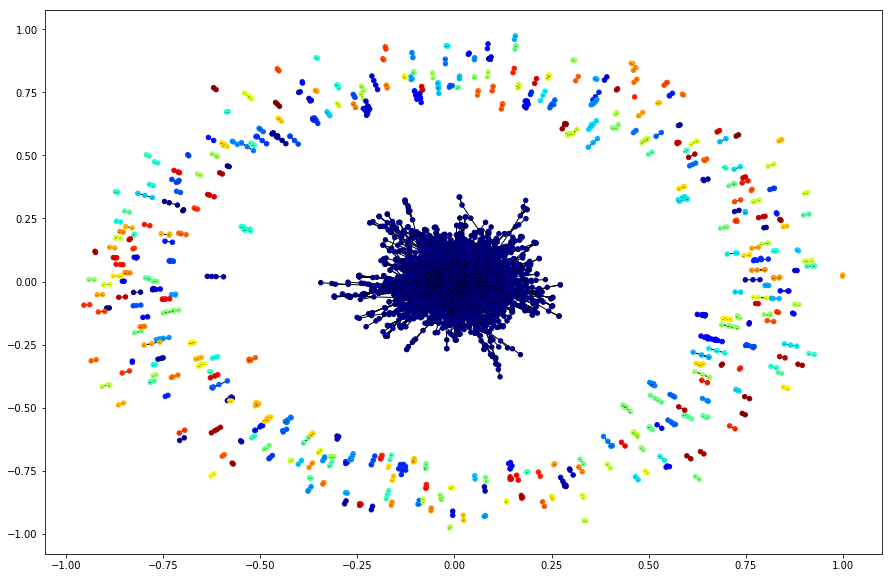

In [8]:
display_communities(G, top_GW)

In [ ]:
display_communities(G0, top_giantGW)

#### -- Clauset-Newman-Moore (greedy modularity)

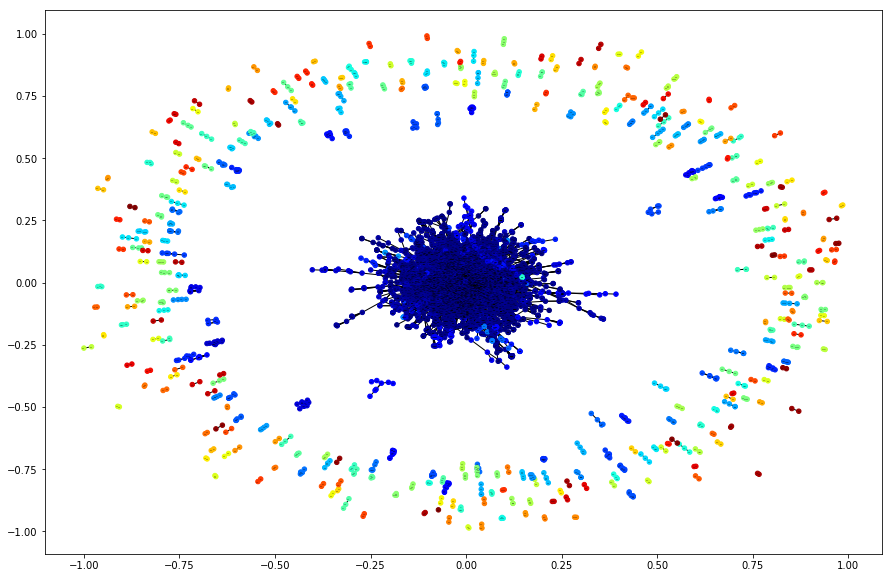

In [10]:
display_communities(G, communities_greedMod)

In [ ]:
display_communities(G0, communities_giantGreedMod)

### Measures summary of the whole graph and giant component

#### -- general statistics of the whole graph

In [ ]:
#Stats on the whole graph
density = nx.density(G)
avg_clust = nx.average_clustering(G)
trans = nx.transitivity(G)
assrt = nx.degree_pearson_correlation_coefficient(G)
diameter = float("Inf")
avg_path_lenght = float("Inf")
if(nx.is_connected(G)): # if is not connected we could not compute diameter and avg path length
    diameter = nx.diameter(G)
    avg_path_lenght = nx.average_shortest_path_length(G)

print("avg degree: ", degree_stat.average())
print("density: ", density)
print("diameter: ", diameter)
print("avg_path_lenght: ", avg_path_lenght)
print("avg_clustering coeff: ", avg_clust)
print("transitivity: ", trans)
print("assortativity: ", assrt)

#### -- assortativity measures of the whole graph

In [ ]:
plt.figure(figsize=(17,10))
plt.title("Degree Correlation Matrix")
sns.heatmap(nx.degree_mixing_matrix(G), cmap="coolwarm").invert_yaxis();

In [ ]:
#plt.plot(nx.k_nearest_neighbors(G).values())
pairs = sorted(nx.k_nearest_neighbors(G).items(), key=lambda pair:pair[0])
plt.figure(figsize=(15,8))
plt.title("Average Degree Connectivity")
plt.plot(list(map(lambda pair:pair[1], pairs)))
plt.xticks(range(len(pairs)),list(map(lambda pair:pair[0], pairs)))
plt.grid()

In [ ]:
vals = list(map(lambda pair: pair[1], sorted(nx.average_neighbor_degree(G).items(), key=lambda pair:pair[0])))
plt.figure(figsize=(15,8))
plt.title("Average Neighbors Degree Value")
plt.plot(vals, 'o')
plt.grid()

#### -- general statistics of the giant component

In [ ]:
# Stats on the Giant Component
degrees = [val for (node, val) in G0.degree]
avg_degree = sum(degrees)/len(degrees)

densityGiant = nx.density(G0)
diameterGiant = nx.diameter(G0)
transGiant = nx.transitivity(G0)
assrtGiant = nx.degree_pearson_correlation_coefficient(G0)
avg_path_lenghtGiant = nx.average_shortest_path_length(G0)
avg_clustGiant = nx.average_clustering(G0)

print("avg degree: ", avg_degree)
print("density: ", densityGiant)
print("diameter: ", diameterGiant)
print("avg_path_lenght: ", avg_path_lenghtGiant)
print("avg_clustering coeff: ", avg_clustGiant)
print("transitivity: ", transGiant)
print("assortativity: ", assrtGiant)

#### -- assortativity measures of the giant component

In [ ]:
plt.figure(figsize=(17,10))
plt.title("Degree Correlation Matrix")
sns.heatmap(nx.degree_mixing_matrix(G0), cmap="coolwarm").invert_yaxis();

In [ ]:
#plt.plot(nx.k_nearest_neighbors(G).values())
pairs = sorted(nx.k_nearest_neighbors(G).items(), key=lambda pair:pair[0])
plt.figure(figsize=(15,8))
plt.title("Average Degree Connectivity")
plt.plot(list(map(lambda pair:pair[1], pairs)))
plt.xticks(range(len(pairs)),list(map(lambda pair:pair[0], pairs)))
plt.grid()

In [ ]:
vals = list(map(lambda pair: pair[1], sorted(nx.average_neighbor_degree(G).items(), key=lambda pair:pair[0])))
plt.figure(figsize=(15,8))
plt.title("Average Neighbors Degree Value")
plt.plot(vals, 'o')
plt.grid()

### Direct question

**Does the graph have the same characteristics of a random or a power-law network?**<br>


In [ ]:
from scipy.stats import poisson

def poisson_distr(average, peak, num):
    arr = []
    rv = poisson(average)
    for i in range(num+1):
        arr.append(rv.pmf(i)*4.5*peak)
        
    plt.plot(arr, 'r', linewidth=2.0)

def powerLaw_distr(peak, num):
    arr = []
    for i in range(1,num+2):
        arr.append(i**(-2.5)*peak)
        
    plt.plot(arr, 'r', linewidth=2.0)

##### -- Random graph testing

In [ ]:
# Random graph has no transitivity or clustering
print("Transitivity: {}\nClustering: {}\nAverage degree: {}".format(trans, avg_clust, degree_stat.average()))

# Degree distribution
degree_stat.barplot()
poisson_distr(degree_stat.average(),
              max(collections.Counter(degree_stat.orderedValues).values()),
              degree_stat.maximum()[1])

# CONTROLLARE avg_degree > log N if true implies that these networks should be broken into isolated clusters
avg_degree > np.log(len(G))

##### -- Power-law distribution
As we seen in the graph below our graph behaves as a power law distribution; many nodes with only a few links, few hubs with large number of links

In [ ]:
degree_stat.barplot()
powerLaw_distr(max(collections.Counter(degree_stat.orderedValues).values()),
              degree_stat.maximum()[1])

**Which are the most important nodes, with respect to a given centrality measure?**<br>


In [ ]:
def most_important(graph, metric, top=10, index=None):
    if index is None:
        res = sorted(dict(metric(graph)).items(), key=lambda item:item[1], reverse=True)[:top]
    else:
        res = sorted(dict(metric(graph)[index]).items(), key=lambda item:item[1], reverse=True)[:top]
        
    return list(map(lambda pair:"{} ({})".format(pair[0],round(pair[1],2)), res))

In [ ]:
display = 10

#degree
print("Best {} nodes in terms of degree are:\n{}\n"
      .format(display, most_important(G, nx.degree, top=display)))
#betweenness
print("Best {} nodes in terms of betweenness are:\n{}\n"
      .format(display, most_important(G, nx.betweenness_centrality, top=display)))
#Closeness
print("Best {} nodes in terms of closeness are:\n{}\n"
      .format(display, most_important(G, nx.closeness_centrality, top=display)))
#Clustering
print("Best {} nodes in terms of clustering are:\n{}\n"
      .format(display, most_important(G, nx.clustering, top=display)))
#Pagerank
print("Best {} nodes in terms of pagerank are:\n{}\n"
      .format(display, most_important(G, nx.pagerank_numpy, top=display)))

#HITS
print("Best {} nodes in terms of HITS are:\n{}\n"
      .format(display, most_important(G, nx.hits_numpy, top=display, index=0)))

**Are the paths short with respect to the size of the network?**<br>
if this ratio is near 0 it means that the short paths are much smaller than the network size; as opposite 
if the value is near 1 it means that the short path is similar to the longest minimum path (geodesic path)


In [ ]:
avg_path_lenght/diameter

**Is the network dense?**<br>


In [ ]:
G.number_of_edges()*2.0/float(G.number_of_nodes()*(G.number_of_nodes()-1))